In [ ]:
from google.colab import drive
drive.mount('/content/drive')

DATA_DIR = "/content/drive/MyDrive/garbage-classification"
base_dataset = datasets.ImageFolder(root=DATA_DIR, transform=None)

import os
print("Classes found:", os.listdir(DATA_DIR))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Classes found: ['plastic', 'metal', 'cardboard', 'paper', 'glass']


In [ ]:
!pip install torch torchvision --quiet

**Import Libraries**

In [ ]:
import os, time, random, copy
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms, models
from torch.optim.lr_scheduler import StepLR

**Exploratory Data Analysis (EDA)**

Class distribution: {'cardboard': 413, 'glass': 511, 'metal': 410, 'paper': 594, 'plastic': 492}


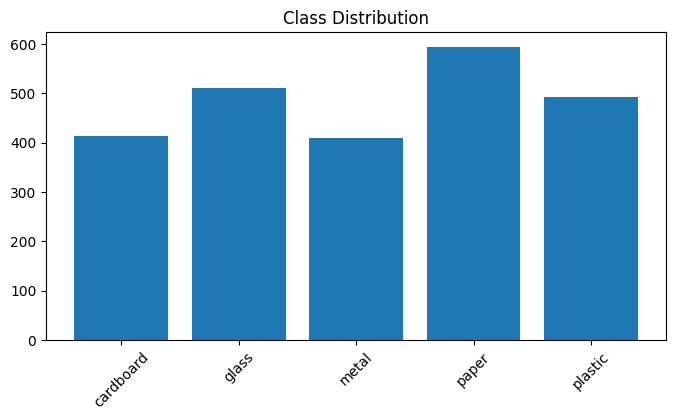

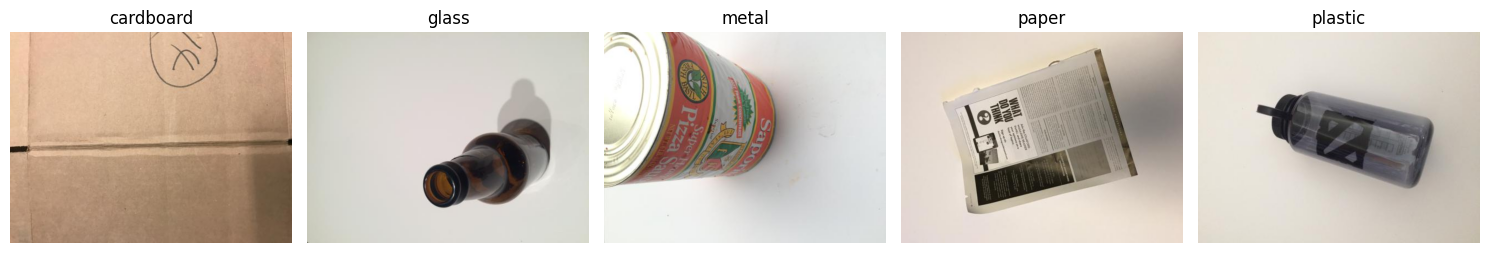

In [ ]:
import matplotlib.pyplot as plt
from collections import Counter
from torchvision import datasets

# Updated class names and counts
class_names = base_dataset.classes
num_classes = len(class_names)

# Class counts
counts = Counter(base_dataset.targets)
print("Class distribution:", {class_names[i]: counts[i] for i in range(num_classes)})

# Plot bar chart
plt.figure(figsize=(8,4))
plt.bar(class_names, [counts[i] for i in range(num_classes)])
plt.xticks(rotation=45)
plt.title("Class Distribution")
plt.show()

# Pick 1 sample index for each class
sample_indices = []
seen = set()
for i, label in enumerate(base_dataset.targets):
    if label not in seen:
        sample_indices.append(i)
        seen.add(label)
    if len(seen) == num_classes:
        break

# Plot one image per class
fig, axes = plt.subplots(1, num_classes, figsize=(3*num_classes, 3))
for ax, idx in zip(axes, sample_indices):
    img, label = base_dataset[idx]
    ax.imshow(img)
    ax.set_title(class_names[label])
    ax.axis("off")
plt.tight_layout()
plt.show()


**Helper Functions**

In [ ]:
def set_seed(seed=42):
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

def build_transforms(img_size=224):
    train_tfms = transforms.Compose([
        transforms.RandomResizedCrop(img_size, scale=(0.7, 1.0)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.02),
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.485, 0.456, 0.406),
                             std=(0.229, 0.224, 0.225)),
    ])
    val_test_tfms = transforms.Compose([
        transforms.Resize(int(img_size * 1.14)),
        transforms.CenterCrop(img_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.485, 0.456, 0.406),
                             std=(0.229, 0.224, 0.225)),
    ])
    return train_tfms, val_test_tfms

def stratified_indices(labels, train_ratio=0.8, val_ratio=0.1, test_ratio=0.1, seed=42):
    num_classes = max(labels) + 1
    per_class = [[] for _ in range(num_classes)]
    for idx, y in enumerate(labels):
        per_class[y].append(idx)
    rng = random.Random(seed)
    train_idx, val_idx, test_idx = [], [], []
    for cls, idxs in enumerate(per_class):
        rng.shuffle(idxs)
        n = len(idxs)
        n_train = int(n * train_ratio)
        n_val = int(n * val_ratio)
        train_idx.extend(idxs[:n_train])
        val_idx.extend(idxs[n_train:n_train+n_val])
        test_idx.extend(idxs[n_train+n_val:])
    rng.shuffle(train_idx); rng.shuffle(val_idx); rng.shuffle(test_idx)
    return train_idx, val_idx, test_idx


**Load Dataset**

In [ ]:
IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 20
LR = 1e-3

train_tfms, val_test_tfms = build_transforms(IMG_SIZE)
base_dataset = datasets.ImageFolder(root=DATA_DIR, transform=None)
class_names = base_dataset.classes
num_classes = len(class_names)
print("Detected Classes:", class_names)

train_idx, val_idx, test_idx = stratified_indices(base_dataset.targets)

train_ds = copy.copy(base_dataset); train_ds.transform = train_tfms
val_ds   = copy.copy(base_dataset); val_ds.transform = val_test_tfms
test_ds  = copy.copy(base_dataset); test_ds.transform = val_test_tfms

train_set, val_set, test_set = Subset(train_ds, train_idx), Subset(val_ds, val_idx), Subset(test_ds, test_idx)

train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
test_loader  = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

Detected Classes: ['cardboard', 'glass', 'metal', 'paper', 'plastic']


**Model Building** - SqueezeNet Model

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.squeezenet1_1(pretrained=True)
# Replace classifier to match num_classes
model.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
model.num_classes = num_classes
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LR)
scheduler = StepLR(optimizer, step_size=7, gamma=0.1)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=SqueezeNet1_1_Weights.IMAGENET1K_V1`. You can also use `weights=SqueezeNet1_1_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/squeezenet1_1-b8a52dc0.pth" to /root/.cache/torch/hub/checkpoints/squeezenet1_1-b8a52dc0.pth
100%|██████████| 4.73M/4.73M [00:00<00:00, 31.8MB/s]


**Training Loop**

In [ ]:
def train_one_epoch():
    model.train()
    total, correct, running_loss = 0, 0, 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
        preds = outputs.argmax(1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    return running_loss/total, correct/total

@torch.no_grad()
def evaluate(loader):
    model.eval()
    total, correct, running_loss = 0, 0, 0
    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        running_loss += loss.item() * images.size(0)
        preds = outputs.argmax(1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    return running_loss/total, correct/total

# Store history for plotting
history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}

best_acc = 0
for epoch in range(1, EPOCHS+1):
    t_loss, t_acc = train_one_epoch()
    v_loss, v_acc = evaluate(val_loader)
    scheduler.step()
    print(f"Epoch {epoch:02d}/{EPOCHS} | "
          f"Train Acc {t_acc*100:.2f}% | Val Acc {v_acc*100:.2f}%")
    if v_acc > best_acc:
        best_acc = v_acc
        torch.save(model.state_dict(), "/content/drive/MyDrive/squeezenet_best.pth")
        print("  ↳ Saved new best model")

Epoch 01/20 | Train Acc 23.78% | Val Acc 24.48%
  ↳ Saved new best model
Epoch 02/20 | Train Acc 26.42% | Val Acc 29.05%
  ↳ Saved new best model
Epoch 03/20 | Train Acc 22.18% | Val Acc 19.92%
Epoch 04/20 | Train Acc 23.53% | Val Acc 24.07%
Epoch 05/20 | Train Acc 30.35% | Val Acc 29.88%
  ↳ Saved new best model
Epoch 06/20 | Train Acc 33.25% | Val Acc 33.61%
  ↳ Saved new best model
Epoch 07/20 | Train Acc 36.61% | Val Acc 31.54%
Epoch 08/20 | Train Acc 37.33% | Val Acc 37.76%
  ↳ Saved new best model
Epoch 09/20 | Train Acc 39.09% | Val Acc 39.83%
  ↳ Saved new best model
Epoch 10/20 | Train Acc 40.69% | Val Acc 38.59%
Epoch 11/20 | Train Acc 49.84% | Val Acc 51.45%
  ↳ Saved new best model
Epoch 12/20 | Train Acc 54.34% | Val Acc 66.80%
  ↳ Saved new best model
Epoch 13/20 | Train Acc 63.13% | Val Acc 69.71%
  ↳ Saved new best model
Epoch 14/20 | Train Acc 66.91% | Val Acc 72.20%
  ↳ Saved new best model
Epoch 15/20 | Train Acc 69.91% | Val Acc 73.44%
  ↳ Saved new best model
Epoch

**Test Evaluation**

In [ ]:
model.load_state_dict(torch.load("/content/drive/MyDrive/squeezenet_best.pth", map_location=device))
test_loss, test_acc = evaluate(test_loader)
print(f"\nFinal Test Accuracy: {test_acc*100:.2f}%")


Final Test Accuracy: 75.10%


**Testing the Model** (Real Time Prediction)

In [ ]:
from google.colab import files
from PIL import Image
import torchvision.transforms as transforms

# Upload image
uploaded = files.upload()

# Get filename
image_path = list(uploaded.keys())[0]
print("Uploaded:", image_path)


Saving Screenshot 2025-08-19 124015.png to Screenshot 2025-08-19 124015.png
Uploaded: Screenshot 2025-08-19 124015.png


In [ ]:
# Load best trained model
model.load_state_dict(torch.load("/content/drive/MyDrive/squeezenet_best.pth", map_location=device))
model.eval()

# Same preprocessing as validation
val_tfms = transforms.Compose([
    transforms.Resize(int(224 * 1.14)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.485, 0.456, 0.406),
                         std=(0.229, 0.224, 0.225)),
])

# Open and preprocess image
img = Image.open(image_path).convert("RGB")
input_tensor = val_tfms(img).unsqueeze(0).to(device)

# Predict
with torch.no_grad():
    outputs = model(input_tensor)
    preds = outputs.argmax(1).item()

print("Predicted class:", class_names[preds])


Predicted class: metal


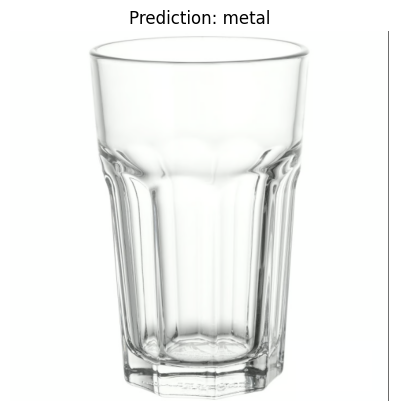

In [ ]:
import matplotlib.pyplot as plt

plt.imshow(img)
plt.title(f"Prediction: {class_names[preds]}")
plt.axis("off")
plt.show()

**Conclusion**

1) Final test accuracy: ~75.8%, which is decent but not very high.

2) Model confused glass with paper - shows difficulty distinguishing between similar-looking classes.

3) SqueezeNet is lightweight (fast and low memory) but may sacrifice accuracy compared to larger models.
